# Part 3 - Topic Modeling

#### Name: Amirhossein Kiani
#### Contact: ahosseinkiani@gmail.com

In this notebook I use sentence transformers, through the library `BerTopic`, to perform topic modeling on the ingredients used in our recipes from the recipes dataset. The results will be used for exploratory data analysis here and in Part 5 of the series of notebooks for this project.

---------------------------------
**Bertopic** is a Python library that provides an implementation of topic modeling using the BERT (Bidirectional Encoder Representations from Transformers) language model. Topic modeling is a technique used to extract the main themes or topics from a collection of documents.

Bertopic leverages `BERT`'s contextual word embeddings to represent the documents and clusters them based on their semantic similarity. It aims to improve upon traditional topic modeling algorithms by utilizing the contextual information captured by BERT, which can lead to more accurate and meaningful topic representations.

Some of the key features of Bertopic include:

- Document clustering: Bertopic allows you to cluster documents based on their topic similarity, providing a way to group related documents together.

- Topic representation: It provides a way to represent each topic as a list of representative keywords, allowing you to understand the main themes within a given dataset.

- Visualization: Bertopic includes visualizations such as interactive topic distribution plots and topic frequencies, which can help in exploring and interpreting the topics within your data.
---------------------------------

By using Bertopic, you can perform topic modeling on your text data and gain insights into the main topics present within the documents.


**NOTE:** The model that is produced in []() can be downloaded from [here](https://www.dropbox.com/scl/fi/i5tryqh4mm3ot3ezeo9ht/bertopic_model_July_8?rlkey=74s7lua8hbycqwilt9xg7luy0&dl=1).

### Table of Contents

- [Imports and Sanity Checks](#imports)
- [Preprocessing the Data](#prep)
- [Topic Modeling with BERTopic](#tm)
    - [Training the Model](#train)
    - [Loading the Trained Model](#load)
    - [Vizualizing Topics and Documents](#viz)
    - [Making Sense of the Topics Extracted](#make)
- [Conclusion](#conc)

## Imports and Sanity Checks <a class ='author' id='imports'></a>

In [1]:
import sys
sys.executable

'C:\\Users\\mathe\\anaconda3\\envs\\deepchef\\python.exe'

In [2]:
# The regular libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
# This allows scrolling through all the columns. Useful for dataframes with too many columns.
pd.set_option('display.max_columns', 100)

In [ ]:
#!pip install --upgrade pandas
#!pip install --upgrade pyarrow

In [4]:
recipes = pd.read_parquet('BasicCleanData.parquet')

In [5]:
recipes.sample(2)

,RecipeId,Name,AuthorId,AuthorName,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,url,ingred_quants,ingred_items,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes,CorrectAggregatedRating
143559,150565.0,Three Onion Casserole,182010,Chef Kate,"From the Silver Palate Good Times Cookbook, th...",[https://img.sndimg.com/food/image/upload/w_55...,Vegetables,"[Vegetable, Oven, < 4 Hours]","[3, 2, 2, 4, 1⁄2, None, 1 1⁄2, 2, 1 1⁄2, 1⁄2]","[butter, yellow onions, red onions, leeks, sal...",8.0,254.7,14.8,8.8,45.0,352.1,18.4,2.8,6.8,10.1,6.0,"[Preheat oven to 350°F, Butter an 8 cup baking...",https://www.food.com/recipe/Three-Onion-Casser...,"[3, 2, 2, 4, 1⁄2, , 1 1⁄2, 2, 1 1⁄2, 1⁄2]","[tablespoons butter, unsalted, large yellow on...",2006,1,6,12,80,4.88
53289,57460.0,Papaya Smoothie,37779,ratherbeswimmin,A luscious smoothie that I first tried while o...,[https://img.sndimg.com/food/image/upload/w_55...,Beverages,"[Beverages, Papaya, Tropical Fruits, Fruit, Lo...","[1, 3⁄4, 1, 1]","[papaya, lime, juice of]",1.0,114.5,0.2,0.1,0.0,13.8,29.5,3.4,9.3,1.3,2.0,[Add all the ingredients into the container of...,https://www.food.com/recipe/Papaya-Smoothie-57460,"[1, 3⁄4, 1, 1]","[medium ripe papaya, peeled,seeded,and chopped...",2003,3,31,20,5,5.00


In [6]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 521707 entries, 0 to 521711
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    521707 non-null  float64
 1   Name                        521707 non-null  object 
 2   AuthorId                    521707 non-null  int32  
 3   AuthorName                  521707 non-null  object 
 4   Description                 521707 non-null  object 
 5   Images                      521707 non-null  object 
 6   RecipeCategory              521707 non-null  object 
 7   Keywords                    521707 non-null  object 
 8   RecipeIngredientQuantities  521707 non-null  object 
 9   RecipeIngredientParts       521707 non-null  object 
 10  ReviewCount                 275009 non-null  float64
 11  Calories                    521707 non-null  float64
 12  FatContent                  521707 non-null  float64
 13  SaturatedFatContent

In [7]:
recipes.describe()

,RecipeId,AuthorId,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes,CorrectAggregatedRating
count,521707.000000,5.217070e+05,275009.000000,521707.000000,521707.000000,521707.000000,521707.000000,5.217070e+05,521707.000000,521707.000000,521707.000000,521707.000000,338974.000000,521707.000000,521707.000000,521707.000000,521707.000000,521707.000000,265965.000000
mean,271408.677923,4.431495e+07,5.228033,484.469542,24.617438,9.559768,86.477785,7.672582e+02,49.089856,3.843741,21.877172,17.471235,8.607716,2007.539565,6.368879,15.619535,14.817407,63.181709,4.437086
std,155254.246153,2.883472e+08,20.382026,1397.983617,111.564048,46.654416,301.999673,4.205911e+03,180.924439,8.606910,142.709206,40.150121,114.425745,3.593220,3.466708,8.824103,6.542659,81.905026,0.765571
min,38.000000,2.700000e+01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1999.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,137005.500000,6.926700e+04,1.000000,174.200000,5.600000,1.500000,3.800000,1.233000e+02,12.800000,0.800000,2.500000,3.500000,4.000000,2005.000000,3.000000,8.000000,12.000000,20.000000,4.000000
50%,271340.000000,2.381910e+05,2.000000,317.100000,13.800000,4.700000,42.600000,3.533000e+02,28.200000,2.200000,6.400000,9.100000,6.000000,2007.000000,6.000000,15.000000,16.000000,40.000000,4.750000
75%,405487.500000,5.630530e+05,4.000000,529.100000,27.400000,10.800000,107.900000,7.922000e+02,51.100000,4.600000,17.900000,25.000000,8.000000,2009.000000,9.000000,23.000000,20.000000,67.000000,5.000000
max,540559.000000,2.002766e+09,3063.000000,612854.600000,64368.100000,26740.600000,130456.400000,1.246921e+06,108294.600000,3012.000000,90682.300000,18396.200000,32767.000000,2020.000000,12.000000,31.000000,23.000000,595.000000,5.000000


## Preprocessing the Data <a class ='author' id='prep'></a>

Typically BERTopic is fitted on paragraphs, sentences, and other standard natural language units, to extract topics. We could follow this approach and apply a model to the items of our `RecipeInstructions` column, which contains all the ingredients of the given recipe, in order to extract recipe-topics. But `RecipeInstructions` congtains lots of other natural language items that are not useful for us. We could preporcess the recipe instrutions to improve the model performance in finding food-topics. Alternativaely, since we are lucky to have a column that *only* contains recipe ingredients -- `RecipeIngredientParts` -- we can just fit our model to to that column without worrying about any noise in the data. So this is what we'll persue belows.

**NOTE** The first option still works very well.

In [9]:
recipes.sample(5)['RecipeIngredientParts']

158743    [sugar, heavy cream, dark corn syrup, salt, ba...
377681    [dill pickle, celery, cucumber, yellow mustard...
241320    [canola oil, soya sauce, garlic powder, onion ...
101890    [mashed sweet potatoes, granulated sugar, dark...
50001     [egg substitute, egg, skim milk, poultry seaso...
Name: RecipeIngredientParts, dtype: object

Let's first create a preprocessing function to avoid any unwanted items (such as commas and other punctuations) in the ingredients list.

**NOTE:** For the most part this function doesn't do much for `RecipeIngredientParts` since the column is fairly clean. I'm leaving the function in its entirety in case one decides to go with performing topic modeling on `RecipeInstructions`, which requires lots of preprocessing.

In this section, we engage with natrual language processing. **Natural Language Processing** (**NLP**) is a field of artificial intelligence that focuses on enabling computers to understand, interpret, and generate human language. It involves a wide range of operations to process and analyze text data. The code provided above demonstrates some of the essential operations performed in NLP for text preprocessing. The given script leverages the contractions, nltk, and spacy libraries to carry out these tasks.

The following `preprocess_text` function first converts the input text to lowercase to ensure uniformity. Then, it tokenizes the text, extracting individual words from the string. Next, it removes common English stop words, such as "the," "and," "is," etc., as they typically carry less meaning for analysis. The function then applies stemming using the Porter Stemmer algorithm, reducing words to their base or root forms. Furthermore, it performs lemmatization, a more advanced word normalization technique that converts words to their dictionary form. Finally, it eliminates punctuation marks from the preprocessed text to make it more suitable for further analysis.

Here are short definitions and examples of the concepts mentioned:

**Stemming:**

- Definition: Stemming is the process of reducing words to their base or root form by removing suffixes or prefixes. It aims to group words with similar meanings under the same root word.
- Example: The stem of the words "running," "runs," and "runner" is "run."

**Lemmatization:**

- Definition: Lemmatization is the process of converting words to their dictionary or base form (lemma). Unlike stemming, lemmatization considers the context of the word and produces valid words that make sense.
- Example: The lemma of the words "was," "were," and "am" is "be."

**Stopwords:**

- Definition: Stopwords are common words like "the," "and," "is," etc., that are frequently used in a language but carry little meaning. They are often removed from the text to reduce noise in NLP tasks.
- Example: In the sentence "The quick brown fox jumps over the lazy dog," the stopwords are "the" and "over."

**Tokenization:**

- Definition: Tokenization is the process of breaking a text into individual words or tokens for analysis. It is a crucial step in NLP to make the text suitable for further processing.
- Example: The sentence "I love natural language processing" is tokenized into individual words: ["I", "love", "natural", "language", "processing"].

**Punctuation Removal:**
- Definition: Punctuation removal involves eliminating punctuation marks like periods, commas, exclamation marks, etc., from the text to simplify the analysis.
- Example: The text "Hello, world!" after punctuation removal becomes "Hello world."

Overall, the provided script showcases a series of crucial NLP operations that are vital for preparing text data before applying sophisticated language processing tasks such as sentiment analysis, topic modeling, or information retrieval. These preprocessing steps help improve the quality and accuracy of NLP models and enable effective communication between machines and humans in natural language.

In [10]:
#!pip install contractions
#!pip install spacy

import contractions
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import spacy
from nltk.stem import WordNetLemmatizer
import string


# Define stopwords
stop_words = set(stopwords.words('english'))
# Define lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the function to preprocess text names
def preprocess_text(text):

    """
    This function performs various operations on a given string in order to clean it up. It:
        - turns all the letters to lower case,
        - extracts all the word-tokens from the strings,
        - removes stop words from the tokens,
        - lemmatizes the list of tokens,
        - removes punctuations from the tokens.
    """
    
    # Lowercase the text
    no_name_text = text.lower()
    
    # Split the text into words
    words = no_name_text.split()
    
    # Remove stopwords
    no_stopword_text = [w for w in words if not w in stop_words]
    
    # Apply stemming to each word
    stemmed_text = [PorterStemmer().stem(word) for word in no_stopword_text]
    
    # Lemmatization
    lematized_text = [lemmatizer.lemmatize(token) for token in stemmed_text]
    
    # Concatenate everything together
    
    concat = ' '.join(lematized_text)
    
    # Create a translation table to remove punctuations
    translator = str.maketrans('', '', string.punctuation)
    
    # Remove punctuations from the concatenated text
    cleaned_text = concat.translate(translator)
    
    return cleaned_text

Let's see how this function performs:

In [11]:
recipes.iloc[44987]['RecipeInstructions']

array(['Preheat oven to 350.',
       'Spray 10-inch springform pan and line bottom with parchment round.',
       'Spray again and dust with cocoa powder.',
       'Grind chocolate and almonds in food processor until fine.',
       'Cream butter and sugar.',
       'Add yolks one at a time, beating well.',
       'Add chocolate/almond mixture and blend well.',
       'Beat whites to soft peaks.',
       'Mix 1/3 of whites into chocolate mixture to lighten (it will be stiff).',
       'Fold remaining whites into chocolate mixture.',
       'Bake until tests done, about 30 minutes.', 'Cool.',
       'Unmold upside down on to platter.'], dtype=object)

In [12]:
preprocess_text(" ".join(list(recipes.iloc[44987]['RecipeInstructions'])))

'preheat oven 350 spray 10inch springform pan line bottom parchment round spray dust cocoa powder grind chocol almond food processor fine cream butter sugar add yolk one time beat well add chocolatealmond mixtur blend well beat white soft peaks mix 13 white chocol mixtur lighten it stiff fold remain white chocol mixture bake test done 30 minutes cool unmold upsid platter'

In [13]:
recipes.iloc[44987]['RecipeIngredientParts']

array(['bittersweet chocolate', 'unsalted butter', 'sugar', 'eggs',
       'cocoa powder'], dtype=object)

In [14]:
preprocess_text(" ".join(list(recipes.iloc[44987]['RecipeIngredientParts'])))

'bittersweet chocol unsalt butter sugar egg cocoa powder'

Now let's create a new column that concatenates all (preprocessed) ingredients of each recipe. The reason we need to concatenate each list into one single string is the way BERTopic works: it won't work if we feed list of word lists, but rather a list of documents, here concatenations of the ingrediengts.

In [15]:
recipes['RecipeInstructionsTokenized'] = recipes['RecipeIngredientParts'].apply((lambda x: preprocess_text(" ".join(x))))
recipes['RecipeInstructionsTokenized']

0          blueberri granul sugar vanilla yogurt lemon juic
1         saffron milk hot green chili pepper onion garl...
2         sugar lemons rind lemon zest fresh water fresh...
3         extra firm tofu eggplant zucchini mushroom soy...
4              plain tomato juic cabbag onion carrot celeri
                                ...                        
521707    fettuccin pasta button mushroom silken tofu ga...
521708                                       sugar cinnamon
521709                   orang appl pear pineappl mint leaf
521710    lobster tail garlic powder parmesan chees lemo...
521711    parmesan chees canola oil flour garlic powder ...
Name: RecipeInstructionsTokenized, Length: 521707, dtype: object

In [16]:
docs = list(recipes['RecipeInstructionsTokenized'])

## Topic Modeling with BERTopic <a class ='author' id='tm'></a>

Now let's import our model and fit it to our data

**NOTE1:** The model that is produced below can be downloaded from [here](https://www.dropbox.com/scl/fi/i5tryqh4mm3ot3ezeo9ht/bertopic_model_July_8?rlkey=74s7lua8hbycqwilt9xg7luy0&dl=1).

**NOTE 2:** I have saved the model. No need to run the following code. Just lead the model and work with it, but running the following code:

        # Load the BERTopic model
        topic_model = BERTopic.load("bertopic_model_July_8")

### Training the Model <a class ='author' id='train'></a>

**DO NOT** run the following cell if you don't want to reproduce the model. The model can be downloaded from [here](https://www.dropbox.com/scl/fi/i5tryqh4mm3ot3ezeo9ht/bertopic_model_July_8?rlkey=74s7lua8hbycqwilt9xg7luy0&dl=1).

In [ ]:
# The code to create the model 
# You can download the model from this address:
#https://www.dropbox.com/scl/fi/i5tryqh4mm3ot3ezeo9ht/bertopic_model_July_8?rlkey=74s7lua8hbycqwilt9xg7luy0&dl=1

'''
Topic Modeling with BERTopic: Minimum Viable Example
References:
[1] https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html
[2] https://maartengr.github.io/BERTopic/getting_started/clustering/clustering.html
[3] https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html
'''
# pip install the following if not installed

from bertopic import BERTopic 
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN


# Turn our `RecipeInstructionsTokenized` into a list
docs = list(recipes['RecipeInstructionsTokenized'])

# Embedding model: See [1] for more details

"""
BERTopic starts with transforming our input documents into numerical representations. Although there are many ways this
can be achieved, we typically use sentence-transformers ("all-MiniLM-L6-v2") as it is quite capable of capturing the
semantic similarity between documents.

However, there is not one perfect embedding model and you might want to be using something entirely different for your
use case. Since BERTopic assumes some independence among steps, we can allow for this modularity.

Also, as a default, BERTopic uses UMAP to perform its dimensionality reduction. To use a UMAP model with custom parameters,
we simply define it and pass it to BERTopic. For more on this, see
https://maartengr.github.io/BERTopic/getting_started/dim_reduction/dim_reduction.html
"""

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")


# Clustering model: See [2] for more details

"""
After reducing the dimensionality of our input embeddings, we need to cluster them into groups of similar embeddings to
extract our topics. This process of clustering is quite important because the more performant our clustering technique
the more accurate our topic representations are.

In BERTopic, we typically use HDBSCAN as it is quite capable of capturing structures with different densities.
However, there is not one perfect clustering model and you might want to be using something entirely different for your
use case. Moreover, what if a new state-of-the-art model is released tomorrow? We would like to be able to use that in
BERTopic, right? Since BERTopic assumes some independence among steps, we can allow for this modularity:
"""

cluster_model = HDBSCAN(min_cluster_size = 15000,
                        metric = 'euclidean',
                        cluster_selection_method = 'eom',
                        prediction_data = True)

# BERTopic model
topic_model = BERTopic(embedding_model = embedding_model,
                       hdbscan_model = cluster_model)

# Fit the model on a corpus
topics, probs = topic_model.fit_transform(docs)

# Save the BERTopic model
topic_model.save("bertopic_model_July_8")

### Loading the Trained Model <a class ='author' id='load'></a>
Here we work with the model that I have trained earlier. I'll explore the topics and do some vizualization. For the codes that were used to train this model see the next section.

**NOTE:** Make sure to import the libraries and the dataset, as well as define the preprocessing function from above, before starting to run these codes.

In [ ]:
# Load the BERTopic model
topic_model = BERTopic.load("bertopic_model_July_8")

In [ ]:
# Get the model parameters
topic_model.get_params()

The original model that I have trained has over 2,400 topics of at least 15 members. To keep things simple for our purposes, I will reduce the number of topics to 300.

In [ ]:
# Check out https://maartengr.github.io/BERTopic/getting_started/topicreduction/topicreduction.html#topic-reduction-after-training

topic_model.reduce_topics(docs, nr_topics=300)

# Access updated topics
topics = topic_model.topics_

In [ ]:
topics = topic_model.topics_
topics

In [ ]:
len(set(topics))

In [ ]:
topic_model_df.columns

In [ ]:
topic_model_df = topic_model.get_document_info(docs)
topic_model_df.sample()

In [ ]:
recipes.sample()

We now try to attach the 300 topics extracted to our recipes in the recipes dataset:

In [ ]:
# TEST: let's do this for the top-10 docs

for i,j in zip(topics[:10],docs[:10]):
    print(f"{j}: {topic_model.generate_topic_labels()[i+1]}")

In [ ]:
# Extract the topics from the docs
# This takes a while to go through

recipes_topics = [topic_model.generate_topic_labels()[i+1] for i in topics]

In [ ]:
# Make sure this has the same lenght as our recipes dataset

len(recipes_topics) == len(recipes)

In [ ]:
# Check out the list of topics

set(recipes_topics)

In [ ]:
# Let's create our new column

recipes['BerTopics'] = recipes_topics

In [ ]:
recipes.head()

In [ ]:
# Save the recipes dataset enhanced with the 300 topics

# recipes.to_parquet('CleanDataWithTopicModeling')

### Vizualizing Topics and Documents <a class ='author' id='viz'></a>

**NOTE:** The interactive vizual bellow will not be shown unless the model is loaded. For that reason, I'm including screenshots of them here to get a sense of them. You can download and use the interactive map [here](https://github.com/amirkiaml/DeepChef-BSTN-Capstone/blob/main/intertopic_dist_map.html).

In [ ]:
# Vizualize the topics

topic_model.visualize_topics()

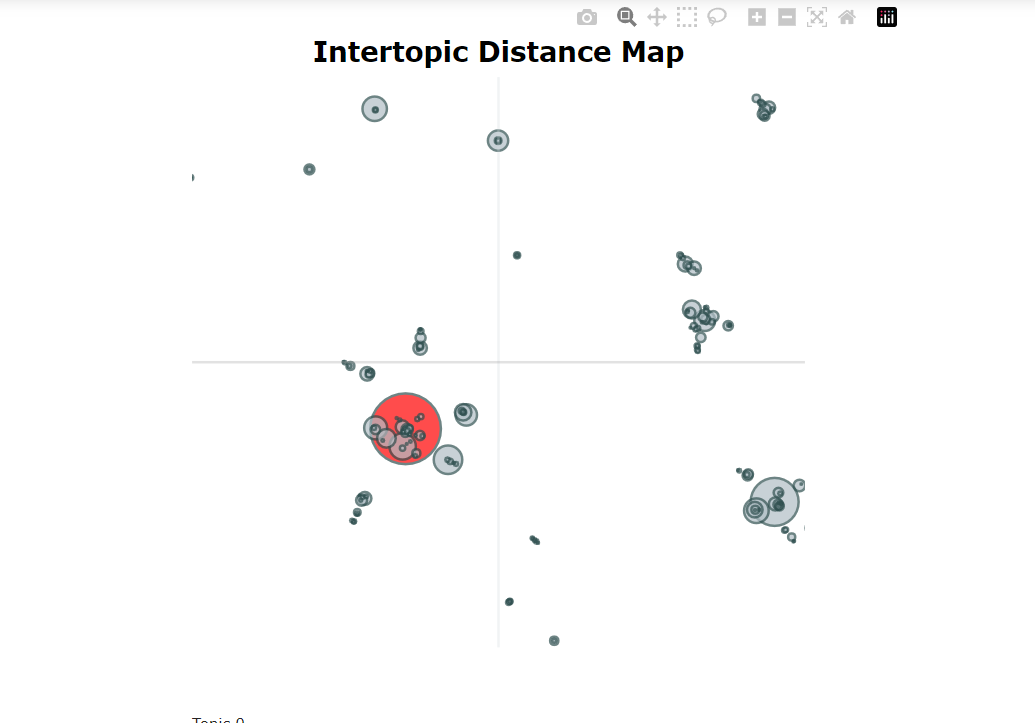

**NOTE:** The interactive vizual bellow will not be shown unless the model is loaded. For that reason, I'm including screenshots of them here to get a sense of them. You can download and use the interactive map [here](https://github.com/amirkiaml/DeepChef-BSTN-Capstone/blob/main/intertopic_dist_map.html).

In [ ]:
# Save the map above as an HTML file
# topic_model.visualize_topics().write_html("intertopic_dist_map_300.html")

In [ ]:
# Vizualize the documents

topic_model.visualize_documents(docs)

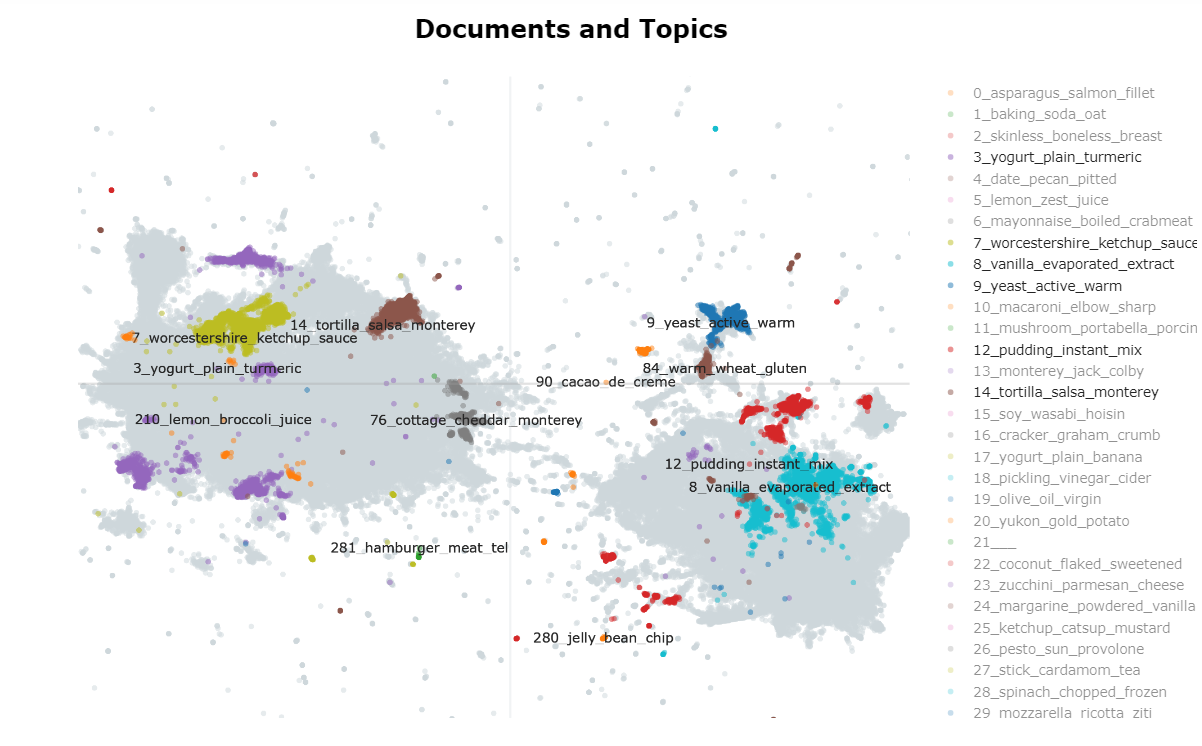

In [ ]:
# Save the vizualization
# topic_model.visualize_documents(docs,hide_document_hover=True).write_html("docs_and_topics_300.html")

## Making Sense of the Topics Extracted <a class ='author' id='make'></a>

Check out [this link](https://maartengr.github.io/BERTopic/getting_started/representation/llm.html#prompts).

**NOTE:** I tried this, and even ChatGPT, on the prodcued topics and the results weren't as impressive.

In [ ]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = "I have a topic described by the following keywords: [KEYWORDS]. Based on the previous keywords, what is this topic about?""

# Create your representation model
generator = pipeline('text2text-generation', model='google/flan-t5-base')
representation_model = TextGeneration(generator)

# Use the representation model in BERTopic on top of the default pipeline
topic_model = BERTopic(representation_model=representation_model)

## Conclusion <a class ='author' id='conc'></a>

We used VerTopic for topic modeling, extracted over 2,400 topics based on the (preprocessed version of) our recipe ingredients, and reduced them to 300 topics for simplicity. The topics extracted in this notebook are used in the EDA phase of the project.